In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
edge_list = data.edge_index.numpy()
edge_list 

array([[ 633, 1862, 2582, ...,  598, 1473, 2706],
       [   0,    0,    0, ..., 2707, 2707, 2707]])

In [5]:
edge_list_tuple = [(edge_list[0, i], edge_list[1,i]) for i in range(edge_list.shape[1])]
edge_list_tuple

[(633, 0),
 (1862, 0),
 (2582, 0),
 (2, 1),
 (652, 1),
 (654, 1),
 (1, 2),
 (332, 2),
 (1454, 2),
 (1666, 2),
 (1986, 2),
 (2544, 3),
 (1016, 4),
 (1256, 4),
 (1761, 4),
 (2175, 4),
 (2176, 4),
 (1629, 5),
 (1659, 5),
 (2546, 5),
 (373, 6),
 (1042, 6),
 (1416, 6),
 (1602, 6),
 (208, 7),
 (269, 8),
 (281, 8),
 (1996, 8),
 (723, 9),
 (2614, 9),
 (476, 10),
 (2545, 10),
 (1655, 11),
 (1839, 11),
 (1001, 12),
 (1318, 12),
 (2661, 12),
 (2662, 12),
 (1701, 13),
 (1810, 13),
 (158, 14),
 (2034, 14),
 (2075, 14),
 (2077, 14),
 (2668, 14),
 (1090, 15),
 (1093, 15),
 (1271, 15),
 (2367, 15),
 (970, 16),
 (1632, 16),
 (2444, 16),
 (2642, 16),
 (24, 17),
 (927, 17),
 (1315, 17),
 (1316, 17),
 (2140, 17),
 (139, 18),
 (1560, 18),
 (1786, 18),
 (2082, 18),
 (2145, 18),
 (1939, 19),
 (1072, 20),
 (2269, 20),
 (2270, 20),
 (2374, 20),
 (2375, 20),
 (1043, 21),
 (2310, 21),
 (39, 22),
 (1234, 22),
 (1702, 22),
 (1703, 22),
 (2238, 22),
 (2159, 23),
 (17, 24),
 (201, 24),
 (598, 24),
 (1636, 24),
 (170

In [6]:
import networkx as nx

Number of nodes 2708
Number of edges 5278


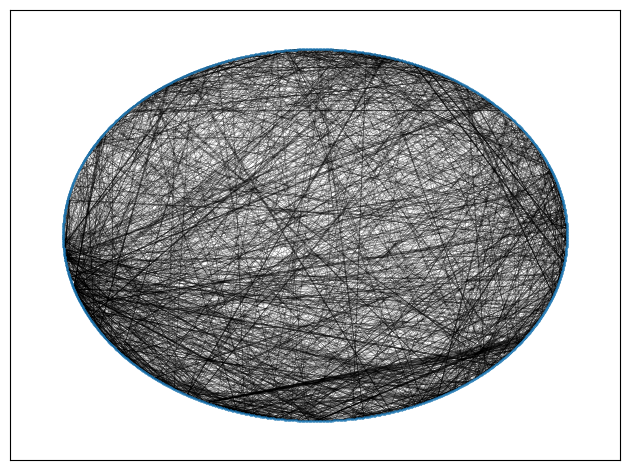

In [23]:
G = nx.Graph()
G.add_edges_from(edge_list_tuple)
pos = nx.shell_layout(G)

nx.draw_networkx(G, pos=pos, with_labels=False, node_size=0.1, width=0.1)
plt.tight_layout()

print(f'Number of nodes {len(G.nodes())}')
print(f'Number of edges {len(G.edges())}')

In [25]:
data.x.size()

torch.Size([2708, 1433])

In [30]:
data = dataset[0]
data.x.size()

torch.Size([2708, 1433])

In [ ]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [35]:
data.y.size()

torch.Size([2708])

## Training a Graph Neural Network (GNN)


In [31]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [32]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)


In [33]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9465
Epoch: 002, Loss: 1.9419
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9290
Epoch: 005, Loss: 1.9199
Epoch: 006, Loss: 1.9140
Epoch: 007, Loss: 1.9079
Epoch: 008, Loss: 1.8992
Epoch: 009, Loss: 1.8876
Epoch: 010, Loss: 1.8764
Epoch: 011, Loss: 1.8656
Epoch: 012, Loss: 1.8626
Epoch: 013, Loss: 1.8460
Epoch: 014, Loss: 1.8329
Epoch: 015, Loss: 1.8225
Epoch: 016, Loss: 1.8167
Epoch: 017, Loss: 1.7995
Epoch: 018, Loss: 1.7878
Epoch: 019, Loss: 1.7716
Epoch: 020, Loss: 1.7568
Epoch: 021, Loss: 1.7563
Epoch: 022, Loss: 1.7342
Epoch: 023, Loss: 1.7092
Epoch: 024, Loss: 1.7015
Epoch: 025, Loss: 1.6671
Epoch: 026, Loss: 1.6757
Epoch: 027, Loss: 1.6609
Epoch: 028, Loss: 1.6355
Epoch: 029, Loss: 1.6339
Epoch: 030, Loss: 1.6102
Epoch: 031, Loss: 1.5964
Epoch: 032, Loss: 1.5721
Epoch: 033, Loss: 1.5570
Epoch: 034, Loss: 1.5445
Epoch: 035, Loss: 1.5093
Epoch: 036, Loss: 1.4889
Epoch: 037, Loss: 1.4776
Epoch: 038, Loss: 1.4704
Epoch: 039, Loss: 1.4263
Epoch: 040, Loss: 1.3972


In [ ]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

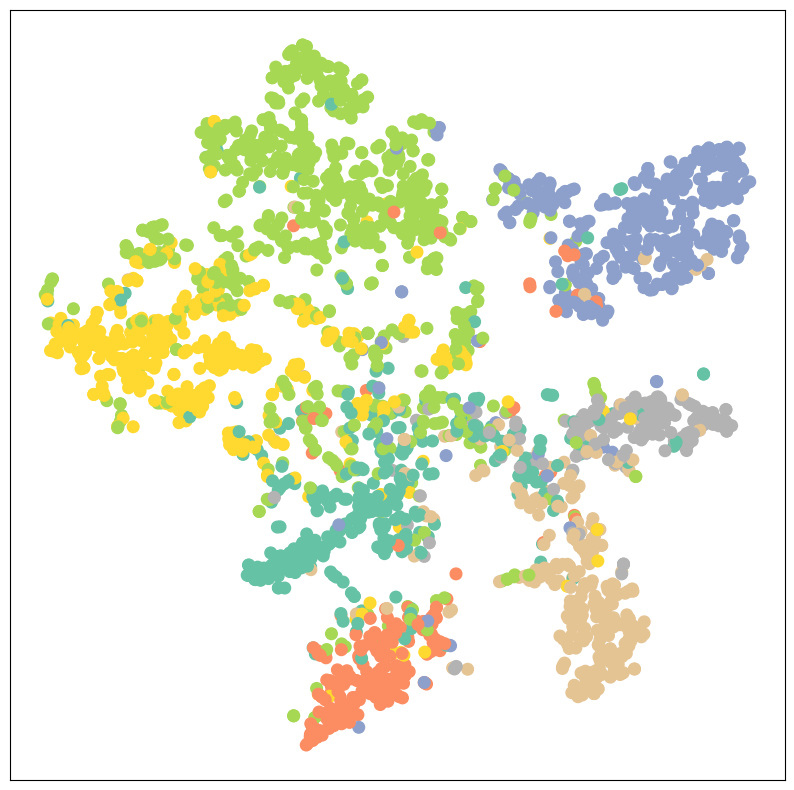

In [12]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [37]:
out.size()

torch.Size([2708, 7])